# Sailing Data Analysis

# Import Data and apply prefilter
Lets import the data we recorded and filter out all non-sensical observations (eg. when the plotter didn't show the current data, or the computer screen went into sleep mode). The following features are available:
- time: Timestamp
- reffen: [-1: Code0 was up, 0: Genua, 1: Reefed to first dot, 2: Reefed to second dot, 3: Reefed to third dot]
- awa: Apparent Wind Angle
- aws: Apparent Wind Speed
- sog: Speed over Ground
- rollen: Tilt of boat in longitude
- twa: True Wind Angle
- tws: True Wind Speed
- stw: Speed through Water
- kurs: Heading of boat

In [1]:
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(font='monospace')

In [2]:
root_path = 'data/own/'
file_names = sorted([f for f in listdir(root_path) if f != '.DS_Store'])

In [3]:
file_names

['sailing_data_17-07-2022_11-25-02.csv',
 'sailing_data_17-07-2022_11-49-31.csv',
 'sailing_data_17-07-2022_11-52-37.csv',
 'sailing_data_17-07-2022_12-13-06.csv',
 'sailing_data_17-07-2022_12-36-42.csv',
 'sailing_data_17-07-2022_13-47-57.csv',
 'sailing_data_17-07-2022_14-35-16.csv',
 'sailing_data_20-07-2022_14-20-47.csv',
 'sailing_data_20-07-2022_15-28-31.csv',
 'sailing_data_20-07-2022_15-43-50.csv',
 'sailing_data_20-07-2022_16-54-50.csv',
 'sailing_data_20-07-2022_18-14-43.csv',
 'sailing_data_20-07-2022_20-06-11.csv']

In [4]:
def applyFilter(data_frame):
    data_frame = data_frame[(data_frame['tws'] > 0) & (data_frame['tws'] < 50)] 
    data_frame = data_frame[(data_frame['aws'] > 0) & (data_frame['aws'] < 50)] 
    data_frame = data_frame[(data_frame['twa'] >= 32) & (data_frame['twa'] <= 365)] 
    data_frame = data_frame[(data_frame['awa'] >= 0) & (data_frame['awa'] <= 365)] 
    data_frame = data_frame[(data_frame['kurs'] >= 0) & (data_frame['kurs'] <= 365)] 
    return data_frame

In [5]:
# Concat all recorded data in one pandas DataFrame and apply filter
f_data_frames = [pd.read_csv(root_path + f, index_col=0) for f in file_names]
sail_data = pd.concat(f_data_frames)
sail_data = applyFilter(sail_data)
sail_data = sail_data.reset_index()

In [6]:
sail_data.head()

,index,time,reffen,awa,aws,sog,rollen,twa,tws,stw,kurs
0,0,17-07-2022 11:25:02,0.0,103,13.1,7.5,0,128,16.2,7.1,173
1,1,17-07-2022 11:25:02,0.0,103,13.1,7.5,0,128,16.2,7.1,173
2,2,17-07-2022 11:25:03,0.0,103,13.2,7.5,1,128,16.2,7.1,172
3,3,17-07-2022 11:25:04,0.0,104,13.2,7.5,2,129,16.4,7.1,172
4,4,17-07-2022 11:25:05,0.0,104,13.2,7.5,0,129,16.5,7.1,173


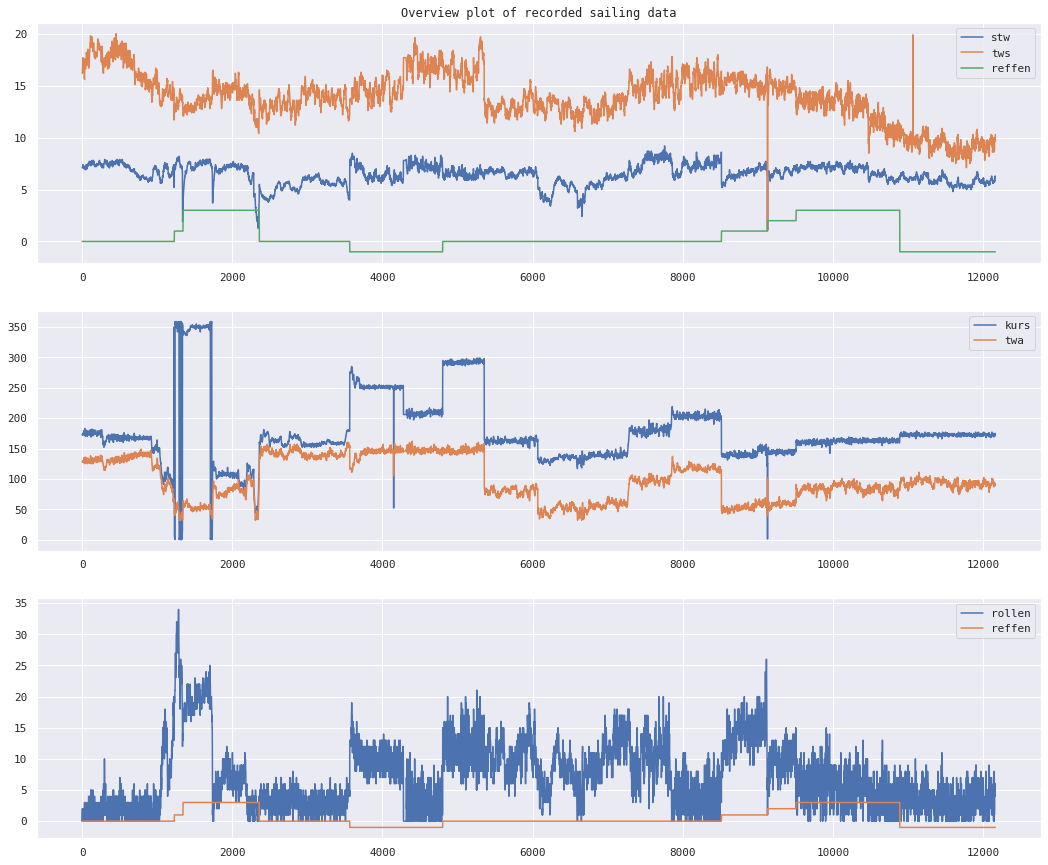

In [7]:
fig = plt.figure(figsize=(18, 15))
fig.add_subplot(311)
plt.title('Overview plot of recorded sailing data')
plt.plot(sail_data.index, sail_data['stw'], label="stw")
plt.plot(sail_data.index, sail_data['tws'], label="tws")
plt.plot(sail_data.index, sail_data['reffen'], label="reffen")
plt.legend()
fig.add_subplot(312)
plt.plot(sail_data.index, sail_data['kurs'], label="kurs")
plt.plot(sail_data.index, sail_data['twa'], label="twa")
plt.legend()
fig.add_subplot(313)
plt.plot(sail_data.index, sail_data['rollen'], label="rollen")
plt.plot(sail_data.index, sail_data['reffen'], label="reffen")
plt.legend()
plt.show()

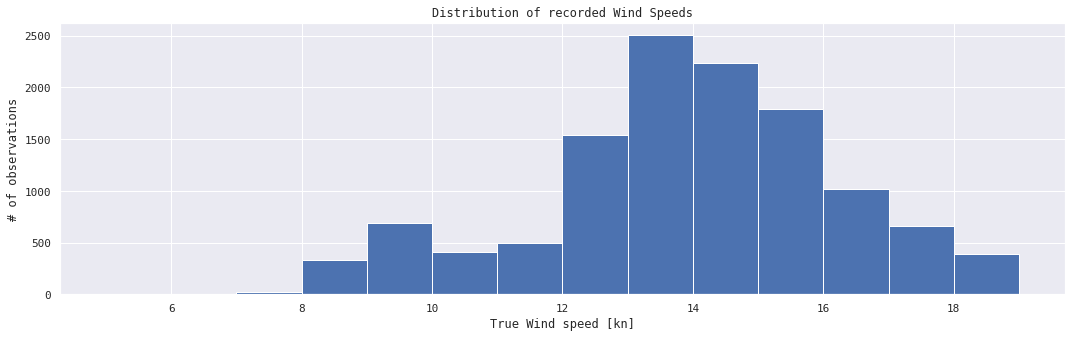

In [8]:
fig = plt.figure(figsize=(18, 5))
plt.hist(sail_data['tws'], bins=np.arange(5, 20))
plt.title('Distribution of recorded Wind Speeds')
plt.xlabel('True Wind speed [kn]')
plt.ylabel('# of observations')
plt.show()

# Compare Code0 performance vs Genua performance
We were especially interested how well the new and bigger foresail (Code0) performs. We recorded sufficient data for a True Wind angle of around 145°. The Code0 outperforms the genua by about 1 knot, across various windspeeds.

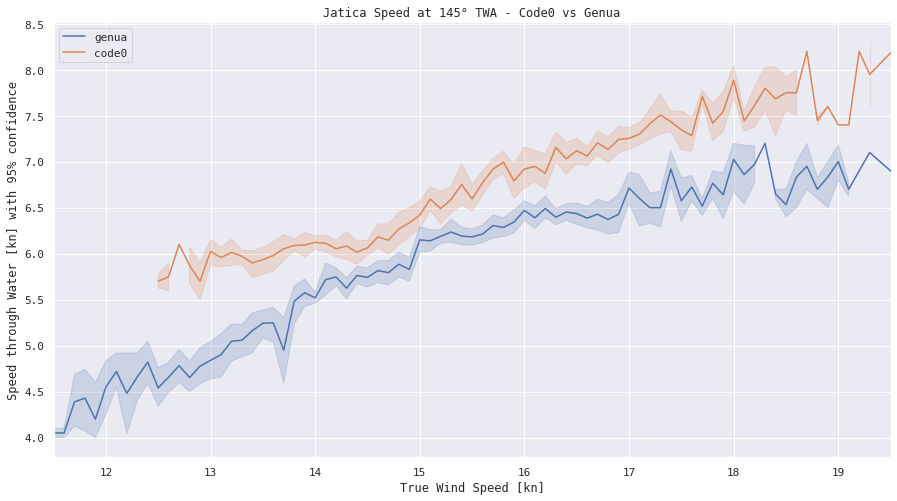

In [9]:
fig = plt.figure(figsize=(15, 8))
plot_data = sail_data[(sail_data['twa'] < 145 + 5) & (sail_data['twa'] > 145 - 5) & (sail_data['reffen'] < 1)].sort_values(by='tws')
plot_data['reffen'] = plot_data['reffen'].replace(-1, 'code0')
plot_data['reffen'] = plot_data['reffen'].replace(0, 'genua')
# plt.plot(code0['tws'], code0['stw'], label='code0', c='k')
# plt.plot(genua['tws'], genua['stw'], label='genua', c='b')
sns.lineplot(data=plot_data, x="tws", y="stw", hue='reffen', ci=95)
plt.legend()
plt.xlim([11.5, 19.5])
ax = plt.gca()
ax.set_yticks(np.arange(4, 9, 0.5))
plt.title('Jatica Speed at 145° TWA - Code0 vs Genua')
plt.xlabel('True Wind Speed [kn]')
plt.ylabel('Speed through Water [kn] with 95% confidence')
plt.savefig('plots/jatica_code0', format='pdf')
plt.show()

# Boat and crew overall performance
We also were curious how well our crew sails in general. First lets see waht data we have recored. We look at the boat speed at various wind speeds and directions. The data is rather noisy. Therefore, we will consider two metrics: Max velocity and KMeans-clustered velocity.

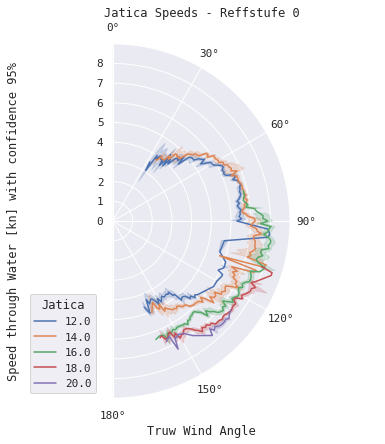

In [10]:
fig = plt.figure(figsize=(10, 30))

for idx, reffstufe in enumerate(np.arange(0, 1)):
    ax = fig.add_subplot(4, 1, idx +1, polar=True)
    # ax = fig.add_subplot(111)
    for idx, tws_curve in enumerate(np.linspace(12, 20, num=5)):
        windcurve_data = sail_data[(sail_data['tws'] <= tws_curve +1) & (sail_data['tws'] > tws_curve - 1) & (sail_data['reffen'] == reffstufe)].sort_values(by='twa')
        windcurve_data['twa'] = np.deg2rad(windcurve_data['twa'].values)
        sns.lineplot(data=windcurve_data, x="twa", y="stw", label=tws_curve)

    ax.set_thetamin(0)
    ax.set_thetamax(180)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xlim([0, np.pi])
    ax.set_ylim([0, 9])
    ax.set_yticks(np.arange(0, 9, 1))

    plt.title('Jatica Speeds - Reffstufe {reffstufe}'.format(reffstufe=reffstufe))
    plt.xlabel('Truw Wind Angle')
    plt.ylabel('Speed through Water [kn] with confidence 95%')
    plt.legend(loc=3, title='Jatica')
    plt.savefig('plots/jatica_data_genua', format='pdf')
plt.show()

## Load reference Data
Online we found an interesting plot by the boats producer. It shows the max boat velocity sailed by a professional 6 men crew. So we digitalized the plot and can compare it with our performance.

In [11]:
reference_data = pd.read_csv('data/reference_data.csv', sep=';', index_col=0, decimal=',')
reference_data.head()

,tws,twa,stw
0,6,32,3.4
1,6,40,4.1
2,6,50,4.9
3,6,60,5.5
4,6,70,5.7


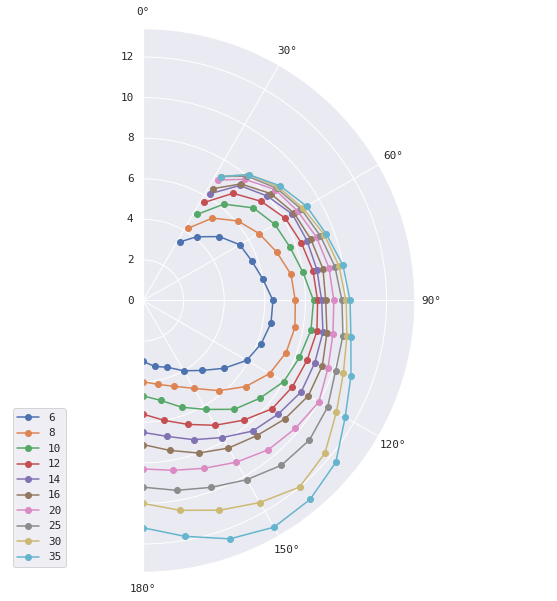

In [12]:
# Define x, y, and xnew to resample at.
x_new = np.linspace(0.5585, np.pi, num=51, endpoint=True)

fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(111)
ax = fig.add_subplot(111, polar=True)
for tws in sorted(reference_data['tws'].unique()):
    windcurve_data = reference_data[reference_data['tws'] == tws].sort_values(by='twa')
    plt.plot(np.deg2rad(windcurve_data['twa']), windcurve_data['stw'], '-o', label=tws)
    parameters = np.polyfit(np.deg2rad(windcurve_data['twa']), windcurve_data['stw'], 8)
    p = np.poly1d(parameters)
    # plt.plot(x_new, p(x_new), '--', label=tws)
plt.legend(loc=3)
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.show()

## Fit Polynom auf Max Daten und vergleiche mit Reference Daten

In [13]:
max_windcurve_data = []
for idx, tws_curve in enumerate(np.linspace(12, 18, num=4)):
    windcurve_data = sail_data[(sail_data['tws'] < tws_curve + 1) & (sail_data['tws'] > tws_curve -1)]

    for twa in np.arange(30, 190, 10):
        angle_data = windcurve_data[(windcurve_data['twa'] < twa + 5) & (windcurve_data['twa'] >= twa - 5)]
        if angle_data.shape[0] > 0:
            max_row = angle_data.loc[angle_data['stw'].idxmax()]
            max_windcurve_data.append([max_row['twa'], max_row['tws'], max_row['stw'], max_row['rollen'], max_row['reffen']])

max_windcurve_data = pd.DataFrame(max_windcurve_data, columns=['twa', 'tws', 'stw', 'rollen', 'reffen'])
max_windcurve_data.head()

,twa,tws,stw,rollen,reffen
0,34,12.8,5.2,4,0.0
1,44,12.5,7.2,26,1.0
2,54,12.8,7.8,27,1.0
3,57,12.8,8.0,32,1.0
4,73,12.6,7.3,9,3.0


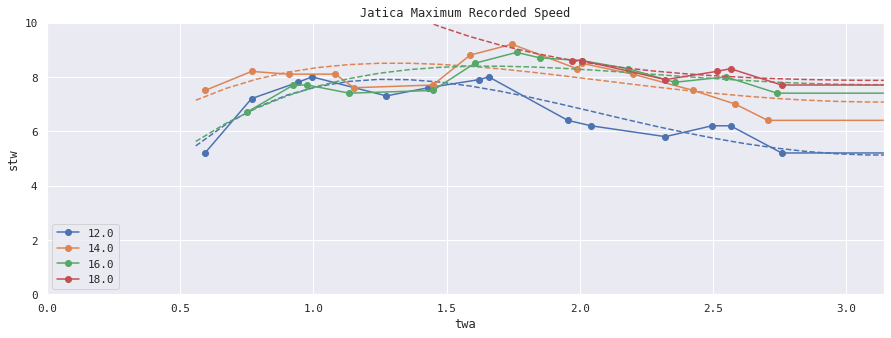

In [14]:
reffstufe = 0

windcurve_colors = sns.color_palette(n_colors=8)

fig = plt.figure(figsize=(15, 5))
x_new = np.linspace(0.5585, 2 * np.pi, num=51, endpoint=True)
# ax = fig.add_subplot(111, polar=True)
ax = fig.add_subplot(111)
for idx, tws_curve in enumerate(np.linspace(12, 18, num=4)):
    windcurve_data = max_windcurve_data[(max_windcurve_data['tws'] < tws_curve + 1) & (max_windcurve_data['tws'] > tws_curve -1)]
    windcurve_data_mirrow = windcurve_data.copy()
    windcurve_data_mirrow['twa'] = 180 + (180 - windcurve_data['twa'].values)
    windcurve_data = pd.concat([windcurve_data, windcurve_data_mirrow]).sort_values(by='twa')
    plt.plot(np.deg2rad(windcurve_data['twa']), windcurve_data['stw'], '-o', label=tws_curve, c=windcurve_colors[idx])
    if windcurve_data.shape[0] > 0:
        parameters = np.polyfit(np.deg2rad(windcurve_data['twa']), windcurve_data['stw'], 4)
        p = np.poly1d(parameters)
        plt.plot(x_new, p(x_new), '--', c=windcurve_colors[idx])
plt.legend(loc=3)

'''
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
'''

plt.title('Jatica Maximum Recorded Speed')
plt.xlabel('twa')
plt.ylabel('stw')
ax.set_xlim([0, np.pi])
ax.set_ylim([0, 10])
plt.savefig('plots/jatica_polynom_max', format='pdf')
plt.show()

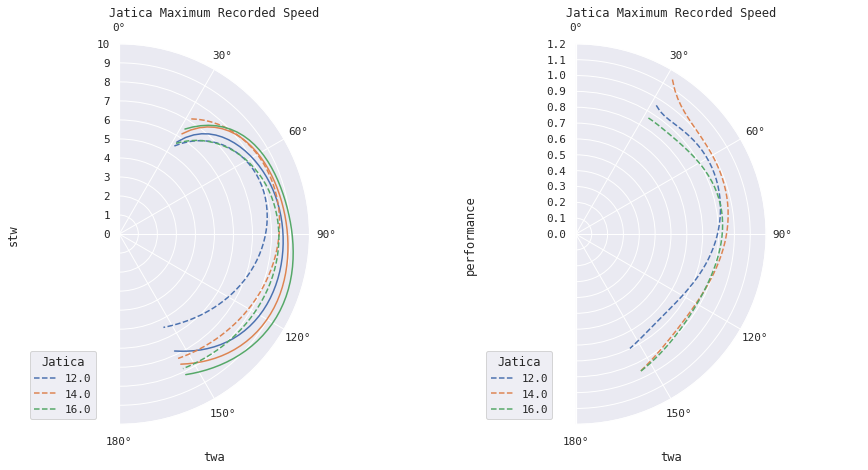

In [15]:
windcurve_colors = sns.color_palette(n_colors=8)

fig = plt.figure(figsize=(15, 8))
x_new = np.linspace(0.5585, 2.7, num=51, endpoint=True)
ax = fig.add_subplot(121, polar=True)
# ax = fig.add_subplot(111)
for idx, tws in enumerate(np.linspace(12, 16, num=3)):
    
    jatica_data = max_windcurve_data[(max_windcurve_data['tws'] <= tws +1) & (max_windcurve_data['tws'] > tws - 1)].sort_values(by='twa')
    jatica_data_mirrow = jatica_data.copy()
    jatica_data_mirrow['twa'] = 180 + (180 - jatica_data['twa'].values)
    jatica_data = pd.concat([jatica_data, jatica_data_mirrow]).sort_values(by='twa')
    
    windcurve_data = reference_data[reference_data['tws'] == tws].sort_values(by='twa')
    
    if windcurve_data.shape[0] > 0:
        parameters = np.polyfit(np.deg2rad(jatica_data['twa']), jatica_data['stw'], 4)
        p = np.poly1d(parameters)
        plt.plot(x_new, p(x_new), '--', c=windcurve_colors[idx], label=tws)
        
        parameters = np.polyfit(np.deg2rad(windcurve_data['twa']), windcurve_data['stw'], 8)
        p = np.poly1d(parameters)
        plt.plot(x_new, p(x_new), '-', c=windcurve_colors[idx])
plt.legend(loc=3, title='Jatica')
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title('Jatica Maximum Recorded Speed')
plt.xlabel('twa')
plt.ylabel('stw')
ax.set_ylim([0, 10])
ax.set_yticks(np.arange(0, 11, 1))

ax = fig.add_subplot(122, polar=True)
# ax = fig.add_subplot(111)
for idx, tws in enumerate(np.linspace(12, 16, num=3)):
    
    jatica_data = max_windcurve_data[(max_windcurve_data['tws'] <= tws +1) & (max_windcurve_data['tws'] > tws - 1)].sort_values(by='twa')
    jatica_data_mirrow = jatica_data.copy()
    jatica_data_mirrow['twa'] = 180 + (180 - jatica_data['twa'].values)
    jatica_data = pd.concat([jatica_data, jatica_data_mirrow]).sort_values(by='twa')
    
    windcurve_data = reference_data[reference_data['tws'] == tws].sort_values(by='twa')
    
    if windcurve_data.shape[0] > 0:
        parameters_jatica = np.polyfit(np.deg2rad(jatica_data['twa']), jatica_data['stw'], 4)
        p_jatica = np.poly1d(parameters_jatica)
        parameters_reference = np.polyfit(np.deg2rad(windcurve_data['twa']), windcurve_data['stw'], 8)
        p_reference = np.poly1d(parameters_reference)
        plt.plot(x_new, p_jatica(x_new)/p_reference(x_new), '--', c=windcurve_colors[idx], label=tws)
        
plt.legend(loc=3, title='Jatica')
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title('Jatica Maximum Recorded Speed')
plt.xlabel('twa')
plt.ylabel('performance')
ax.set_yticks(np.arange(0, 1.3, 0.1))
ax.set_ylim([0, 1.2])
plt.savefig('plots/jatica_performance_max', format='pdf')
plt.show()

## KMeans Clustering

In [16]:
from sklearn.preprocessing import StandardScaler

features = ['reffen', 'tws', 'twa', 'stw', 'rollen']
X = sail_data[features]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pd.DataFrame(X, columns=features).head()

,reffen,tws,twa,stw,rollen
0,-0.3672,0.980452,0.840114,0.655901,-1.344803
1,-0.3672,0.980452,0.840114,0.655901,-1.344803
2,-0.3672,0.980452,0.840114,0.655901,-1.156934
3,-0.3672,1.066372,0.869118,0.655901,-0.969066
4,-0.3672,1.109331,0.869118,0.655901,-1.344803


In [17]:
from sklearn.cluster import KMeans
n_clusters = 200
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
yhat = kmeans.predict(X)
clusters_identified = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
clusters_identified['reffen'] = np.rint(clusters_identified['reffen'])

In [18]:
clusters_identified['nr_observations'] = [X[yhat == i].shape[0] for i in range(n_clusters)]
clusters_identified['stw_std'] = [X[yhat == i][:, features.index('stw')].std() for i in range(n_clusters)]
clusters_identified['twa_std'] = [X[yhat == i][:, features.index('twa')].std() for i in range(n_clusters)]
clusters_identified['reffen_std'] = [X[yhat == i][:, features.index('reffen')].std() for i in range(n_clusters)]
display(clusters_identified.head(5))

,reffen,tws,twa,stw,rollen,nr_observations,stw_std,twa_std,reffen_std
0,-0.0,15.914679,139.055046,6.349541,1.733945,109,0.182564,0.108370,5.551115e-17
1,-0.0,12.383333,82.500000,6.222222,8.763889,72,0.144105,0.102774,5.551115e-17
2,3.0,13.592857,85.904762,7.114286,6.619048,126,0.133656,0.121055,4.440892e-16
3,1.0,14.835897,61.025641,7.353846,13.923077,39,0.173041,0.110198,0.000000e+00
4,-0.0,16.265476,116.619048,7.433333,6.202381,84,0.182455,0.109709,5.551115e-17


In [19]:
# mean_std = np.mean(clusters_identified[['stw_std', 'twa_std']].values, axis=1)
clusters_identified = clusters_identified[(clusters_identified['stw_std'] < 0.3) & (clusters_identified['twa_std'] < 0.3)]
yhat_identified = [n_clusters + 5 if i not in clusters_identified.index else i for i in yhat]
clusters_identified

,reffen,tws,twa,stw,rollen,nr_observations,stw_std,twa_std,reffen_std
0,-0.0,15.914679,139.055046,6.349541,1.733945,109,0.182564,0.108370,5.551115e-17
1,-0.0,12.383333,82.500000,6.222222,8.763889,72,0.144105,0.102774,5.551115e-17
2,3.0,13.592857,85.904762,7.114286,6.619048,126,0.133656,0.121055,4.440892e-16
3,1.0,14.835897,61.025641,7.353846,13.923077,39,0.173041,0.110198,0.000000e+00
4,-0.0,16.265476,116.619048,7.433333,6.202381,84,0.182455,0.109709,5.551115e-17
...,...,...,...,...,...,...,...,...,...
195,3.0,11.122222,40.666667,1.644444,0.666667,9,0.279881,0.124565,2.220446e-16
196,-0.0,13.708451,77.549296,6.788732,14.014085,71,0.218739,0.128683,5.551115e-17
197,-1.0,9.669444,90.944444,5.925000,7.750000,36,0.177675,0.105454,0.000000e+00
198,-1.0,16.747458,148.779661,6.945763,0.779661,59,0.206640,0.117976,2.220446e-16


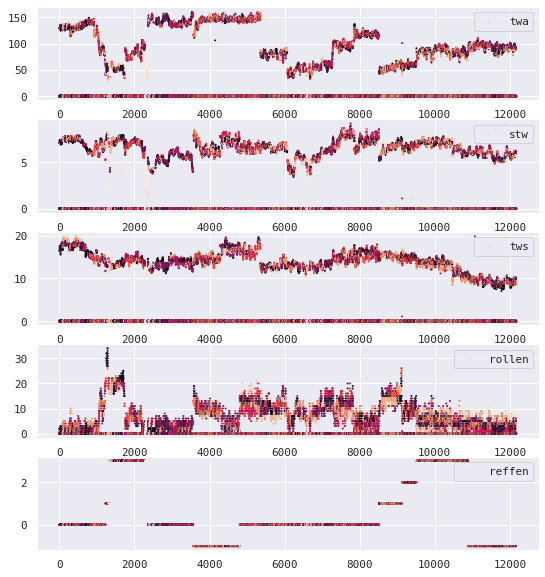

In [20]:
fig = plt.figure(figsize=(9, 10))
fig.add_subplot(511)
plt.scatter(sail_data.index, sail_data['twa'], label="twa", c=yhat_identified, s=1)
plt.scatter(sail_data.index, np.zeros_like(sail_data.index), c=yhat_identified, s=3)
plt.legend()
fig.add_subplot(512)
plt.scatter(sail_data.index, sail_data['stw'], label="stw", c=yhat_identified, s=1)
plt.scatter(sail_data.index, np.zeros_like(sail_data.index), c=yhat_identified, s=3)
plt.legend()
fig.add_subplot(513)
plt.scatter(sail_data.index, sail_data['tws'], label="tws", c=yhat_identified, s=1)
plt.scatter(sail_data.index, np.zeros_like(sail_data.index), c=yhat_identified, s=3)
plt.legend()
fig.add_subplot(514)
plt.scatter(sail_data.index, sail_data['rollen'], label="rollen", c=yhat_identified, s=1)
plt.scatter(sail_data.index, np.zeros_like(sail_data.index), c=yhat_identified, s=3)
plt.legend()
fig.add_subplot(515)
plt.scatter(sail_data.index, sail_data['reffen'], label="reffen", c=yhat_identified, s=1)
plt.legend()
plt.show()

## Fit Polynom auf Clusters und vergleiche mit Reference Daten

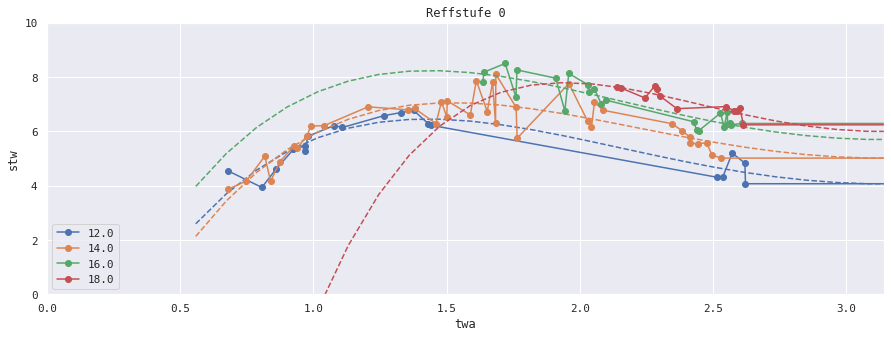

In [21]:
reffstufe = 0

windcurve_colors = sns.color_palette(n_colors=8)

fig = plt.figure(figsize=(15, 5))
x_new = np.linspace(0.5585, 2 * np.pi, num=51, endpoint=True)
# ax = fig.add_subplot(111, polar=True)
ax = fig.add_subplot(111)
for idx, tws_curve in enumerate(np.linspace(12, 18, num=4)):
    
    windcurve_data = clusters_identified[(clusters_identified['tws'] <= tws_curve +1) & (clusters_identified['tws'] > tws_curve - 1) & (clusters_identified['reffen'] == reffstufe)].sort_values(by='twa')
    windcurve_data_mirrow = windcurve_data.copy()
    windcurve_data_mirrow['twa'] = 180 + (180 - windcurve_data['twa'].values)
    windcurve_data = pd.concat([windcurve_data, windcurve_data_mirrow]).sort_values(by='twa')
    plt.plot(np.deg2rad(windcurve_data['twa']), windcurve_data['stw'], '-o', label=tws_curve, c=windcurve_colors[idx])
    if windcurve_data.shape[0] > 0:
        parameters = np.polyfit(np.deg2rad(windcurve_data['twa']), windcurve_data['stw'], 4)
        p = np.poly1d(parameters)
        plt.plot(x_new, p(x_new), '--', c=windcurve_colors[idx])
plt.legend(loc=3)
'''
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
'''
plt.title('Reffstufe {reffstufe}'.format(reffstufe=reffstufe))
plt.xlabel('twa')
plt.ylabel('stw')
ax.set_xlim([0, np.pi])
ax.set_ylim([0, 10])
plt.savefig('plots/jatica_polynom', format='pdf')
plt.show()

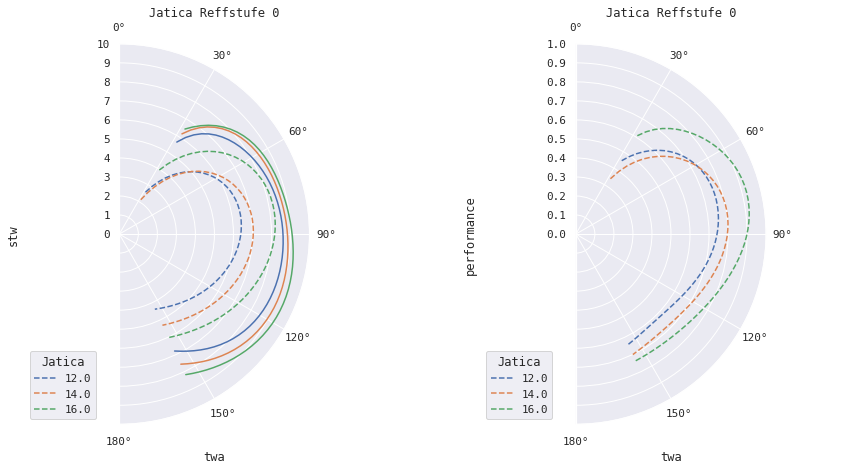

In [22]:
reffstufe = 0

windcurve_colors = sns.color_palette(n_colors=8)

fig = plt.figure(figsize=(15, 8))
x_new = np.linspace(0.5585, 2.7, num=51, endpoint=True)
ax = fig.add_subplot(121, polar=True)
# ax = fig.add_subplot(111)
for idx, tws in enumerate(np.linspace(12, 16, num=3)):
    
    jatica_data = clusters_identified[(clusters_identified['tws'] <= tws +1) & (clusters_identified['tws'] > tws - 1) & (clusters_identified['reffen'] == reffstufe)].sort_values(by='twa')
    jatica_data_mirrow = jatica_data.copy()
    jatica_data_mirrow['twa'] = 180 + (180 - jatica_data['twa'].values)
    jatica_data = pd.concat([jatica_data, jatica_data_mirrow]).sort_values(by='twa')
    
    windcurve_data = reference_data[reference_data['tws'] == tws].sort_values(by='twa')
    
    if windcurve_data.shape[0] > 0:
        parameters = np.polyfit(np.deg2rad(jatica_data['twa']), jatica_data['stw'], 4)
        p = np.poly1d(parameters)
        plt.plot(x_new, p(x_new), '--', c=windcurve_colors[idx], label=tws)
        
        parameters = np.polyfit(np.deg2rad(windcurve_data['twa']), windcurve_data['stw'], 8)
        p = np.poly1d(parameters)
        plt.plot(x_new, p(x_new), '-', c=windcurve_colors[idx])
plt.legend(loc=3, title='Jatica')
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title('Jatica Reffstufe {reffstufe}'.format(reffstufe=reffstufe))
plt.xlabel('twa')
plt.ylabel('stw')
ax.set_ylim([0, 10])
ax.set_yticks(np.arange(0, 11, 1))

ax = fig.add_subplot(122, polar=True)
# ax = fig.add_subplot(111)
for idx, tws in enumerate(np.linspace(12, 16, num=3)):
    
    jatica_data = clusters_identified[(clusters_identified['tws'] <= tws +1) & (clusters_identified['tws'] > tws - 1) & (clusters_identified['reffen'] == reffstufe)].sort_values(by='twa')
    jatica_data_mirrow = jatica_data.copy()
    jatica_data_mirrow['twa'] = 180 + (180 - jatica_data['twa'].values)
    jatica_data = pd.concat([jatica_data, jatica_data_mirrow]).sort_values(by='twa')
    
    windcurve_data = reference_data[reference_data['tws'] == tws].sort_values(by='twa')
    
    if windcurve_data.shape[0] > 0:
        parameters_jatica = np.polyfit(np.deg2rad(jatica_data['twa']), jatica_data['stw'], 4)
        p_jatica = np.poly1d(parameters_jatica)
        parameters_reference = np.polyfit(np.deg2rad(windcurve_data['twa']), windcurve_data['stw'], 8)
        p_reference = np.poly1d(parameters_reference)
        plt.plot(x_new, p_jatica(x_new)/p_reference(x_new), '--', c=windcurve_colors[idx], label=tws)
        
plt.legend(loc=3, title='Jatica')
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title('Jatica Reffstufe {reffstufe}'.format(reffstufe=reffstufe))
plt.xlabel('twa')
plt.ylabel('performance')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim([0, 1])
plt.savefig('plots/jatica_performance', format='pdf')
plt.show()

# Appendix

## Appendix 1: Optimal reef at 55° TWA

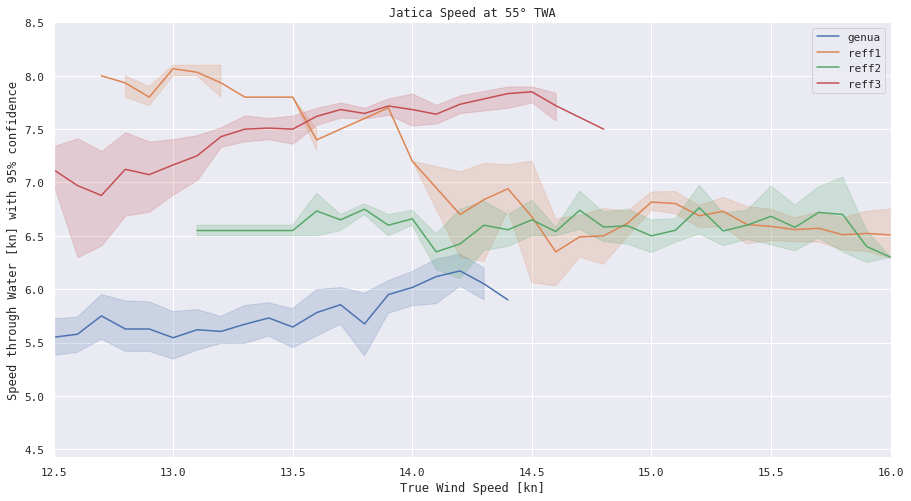

In [23]:
fig = plt.figure(figsize=(15, 8))
plot_data = sail_data[(sail_data['twa'] < 55 + 5) & (sail_data['twa'] > 55 - 5) & (sail_data['stw'] > 4)].sort_values(by='tws')
plot_data['reffen'] = plot_data['reffen'].replace(0, 'genua')
plot_data['reffen'] = plot_data['reffen'].replace(1, 'reff1')
plot_data['reffen'] = plot_data['reffen'].replace(2, 'reff2')
plot_data['reffen'] = plot_data['reffen'].replace(3, 'reff3')
sns.lineplot(data=plot_data, x="tws", y="stw", hue='reffen', ci=95, hue_order=['genua', 'reff1', 'reff2', 'reff3'])
plt.legend()
plt.xlim([12.5, 16])
ax = plt.gca()
ax.set_yticks(np.arange(4.5, 9, 0.5))
plt.title('Jatica Speed at 55° TWA')
plt.xlabel('True Wind Speed [kn]')
plt.ylabel('Speed through Water [kn] with 95% confidence')
plt.savefig('plots/jatica_55_reff', format='pdf')
plt.show()

## Appendix 2: KNN model on clusters

Total of 16 clusters in range 10
Total of 31 clusters in range 12
Total of 72 clusters in range 14
Total of 48 clusters in range 16
Total of 17 clusters in range 18


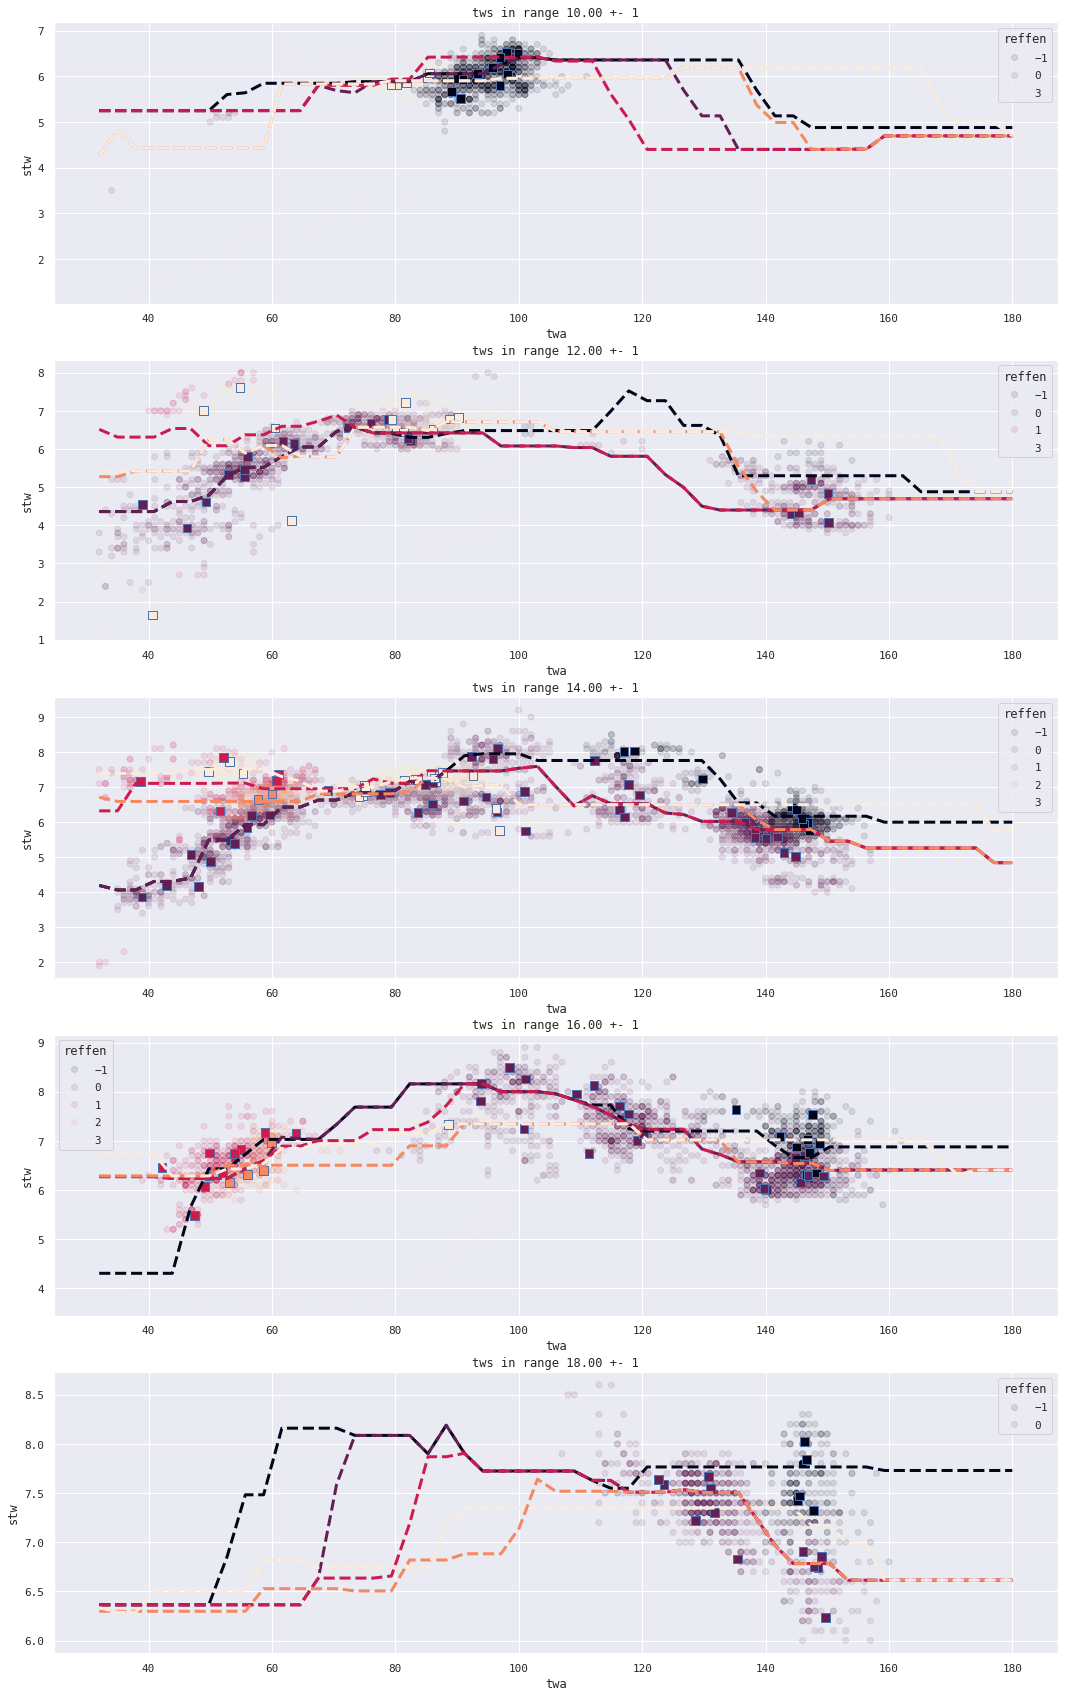

In [24]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=3)
features = ['twa', 'tws', 'reffen']
X = clusters_identified[features]
y = clusters_identified['stw']

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=features)

model.fit(X, y)

tws_interested_array = [10, 12, 14, 16, 18]
twa_new = np.linspace(32, 180, num=51)
fig = plt.figure(figsize=(18, 30))
for idx, tws_interested in enumerate(tws_interested_array):
    fig.add_subplot(len(tws_interested_array), 1, idx+1)
    intersting_data = sail_data[(sail_data['tws'] < tws_interested + 1) & (sail_data['tws'] > tws_interested -1)]
    interesting_clusters = clusters_identified[(clusters_identified['tws'] < tws_interested + 1) & (clusters_identified['tws'] > tws_interested -1)]
    scatter = plt.scatter(intersting_data['twa'], intersting_data['stw'], c=intersting_data['reffen'], alpha=0.1, vmin=-1, vmax=3)
    plt.scatter(interesting_clusters['twa'], interesting_clusters['stw'], c=interesting_clusters['reffen'], marker='s', s=75, edgecolors='b', vmin=-1, vmax=3)
    
    def predict_reffen(tws, reff_stufe):
        twa_new = np.linspace(32, 180, num=51)
        tws_new = np.ones_like(twa_new)*tws
        reffen_new = np.ones_like(twa_new)*reff_stufe
        X_predict = pd.DataFrame(np.array([twa_new, tws_new, reffen_new]).T, columns=features)
        X_predict = pd.DataFrame(scaler.transform(X_predict), columns=features)
        yhat = model.predict(X_predict)
        return yhat

    color_palette = sns.color_palette("rocket", as_cmap=True)
    used_colors = color_palette.__call__(np.linspace(0,1, 5))

    for reff_stufe in [-1, 0, 1, 2, 3]:
        plt.plot(twa_new, predict_reffen(tws_interested, reff_stufe), c=used_colors[int(reff_stufe)+1], linewidth=3, alpha=1, linestyle='--')

    plt.legend(*scatter.legend_elements(), title='reffen')
    plt.xlabel('twa')
    plt.ylabel('stw')
    plt.title('tws in range {windspeed:.2f} +- 1'.format(windspeed=tws_interested))
    print('Total of {clusters} clusters in range {tws_interested}'.format(clusters=interesting_clusters.shape[0], tws_interested=tws_interested))

    plt.savefig('plots/knn_prediction', format='pdf')    
plt.show()